## Build & Train Model

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np  # linear algebra
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.model_selection

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## our modules
import scripts.tools as tools
import scripts.visualization as visualization
from scripts.my_image_generator import MyImageDataGenerator
import scripts.models as models

tf.autograph.set_verbosity(0)

## Handy constants
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
TRAINING_BATCH = 32
VALIDATION_BATCH = 64

2021-11-05 20:55:22.562127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 20:55:22.568099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 20:55:22.568353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = tools.load_nih_dataset('data/')

# Split the 'Finding Labels' column into binary labels
all_xray_df, disease_labels = tools.split_findings(all_xray_df)

Scans found: 112120 , Total Headers 112120


In [3]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda flag: 'pneumonia' if flag == 1 else 'no finding')

In [4]:
print("NIH X-ray dataset has been loaded :")
all_xray_df.sample(3)

NIH X-ray dataset has been loaded :


Image Index               Finding Labels  Follow-up #  Patient ID  \
19270  00005098_000.png                   No Finding            0        5098   
89224  00022147_005.png                 Cardiomegaly            5       22147   
84073  00020671_017.png  Effusion|Pleural_Thickening           17       20671   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
19270           19              M            PA                 2500     2048   
89224           37              F            PA                 2674     2777   
84073           39              M            PA                 2974     2991   

       OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia Infiltration  Mass  \
19270                        0.171  ...       0.0     0.0          0.0   0.0   
89224                        0.143  ...       0.0     0.0          0.0   0.0   
84073                        0.143  ...       0.0     0.0          0.0   0.0   

       No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
19270         1.0     0.0                 0.0        0.0           0.0   
89224         0.0     0.0                 0.0        0.0           0.0   
84073         0.0     0.0                 1.0        0.0           0.0   

       pneumonia_class  
19270       no finding  
89224       no finding  
84073       no finding  

[3 rows x 29 columns]

## Create your training and testing data:

In [5]:
training_df, fda_df = sklearn.model_selection.train_test_split(all_xray_df,
                                                              test_size=0.2,
                                                              stratify=all_xray_df['Pneumonia'])

train_df, valid_df = tools.split_train_validation(training_df,
                                         validation_size=0.4,
                                         train_positive_ratio=0.5,
                                         validation_positive_ratio=0.25)

In [6]:
n_training_samples = len(train_df)
n_training_positive = train_df.Pneumonia.sum()
n_training_negative = n_training_samples - n_training_positive
print(
    f'Training dataframe is composed of {n_training_samples} samples, in which {n_training_positive} are positive and {n_training_negative} are negative.')
print(
    f'This confirms then the {100 * n_training_positive / n_training_samples}/{100 * n_training_negative / n_training_samples}% split between positive and negative labels.')
train_df.head()

Training dataframe is composed of 1374 samples, in which 687.0 are positive and 687.0 are negative.
This confirms then the 50.0/50.0% split between positive and negative labels.


Image Index                              Finding Labels  \
86153  00021243_001.png                                   Pneumonia   
57329  00014223_012.png                Edema|Infiltration|Pneumonia   
68084  00016801_009.png  Edema|Effusion|Infiltration|Mass|Pneumonia   
43164  00011140_013.png                Edema|Infiltration|Pneumonia   
72661  00017912_001.png                       Atelectasis|Pneumonia   

       Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
86153            1       21243           28              M            PA   
57329           12       14223           27              M            AP   
68084            9       16801           48              F            AP   
43164           13       11140           40              F            AP   
72661            1       17912           55              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
86153                 2588     2824                        0.143  ...   
57329                 2048     2500                        0.168  ...   
68084                 2500     2048                        0.168  ...   
43164                 2500     2048                        0.168  ...   
72661                 2992     2991                        0.143  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
86153       0.0     0.0          0.0   0.0         0.0     0.0   
57329       0.0     0.0          1.0   0.0         0.0     0.0   
68084       0.0     0.0          1.0   1.0         0.0     0.0   
43164       0.0     0.0          1.0   0.0         0.0     0.0   
72661       0.0     0.0          0.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
86153                 0.0        1.0           0.0        pneumonia  
57329                 0.0        1.0           0.0        pneumonia  
68084                 0.0        1.0           0.0        pneumonia  
43164                 0.0        1.0           0.0        pneumonia  
72661                 0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [7]:
n_validation_samples = len(valid_df)
n_validation_positive = valid_df.Pneumonia.sum()
n_validation_negative = n_validation_samples - n_validation_positive
print(
    f'Validation dataframe is composed of {n_validation_samples} samples, in which {n_validation_positive} are positive and {n_validation_negative} are negative.')
print(
    f'This confirms then the {100 * n_validation_positive / n_validation_samples}/{100 * n_validation_negative / n_validation_samples}% split between positive and negative labels.')
valid_df.head()

Validation dataframe is composed of 1832 samples, in which 458.0 are positive and 1374.0 are negative.
This confirms then the 25.0/75.0% split between positive and negative labels.


Image Index                      Finding Labels  Follow-up #  \
83580  00020505_022.png                           Pneumonia           22   
45414  00011638_000.png               Atelectasis|Pneumonia            0   
26763  00007007_007.png  Atelectasis|Infiltration|Pneumonia            7   
40451  00010531_012.png                           Pneumonia           12   
23640  00006260_001.png                           Pneumonia            1   

       Patient ID  Patient Age Patient Gender View Position  \
83580       20505           51              M            AP   
45414       11638           66              F            PA   
26763        7007           45              F            AP   
40451       10531           28              F            AP   
23640        6260           62              M            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
83580                 3056     2544                        0.139  ...   
45414                 2992     2991                        0.143  ...   
26763                 2500     2048                        0.171  ...   
40451                 3056     2544                        0.139  ...   
23640                 2992     2991                        0.143  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
83580       0.0     0.0          0.0   0.0         0.0     0.0   
45414       0.0     0.0          0.0   0.0         0.0     0.0   
26763       0.0     0.0          1.0   0.0         0.0     0.0   
40451       0.0     0.0          0.0   0.0         0.0     0.0   
23640       0.0     0.0          0.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
83580                 0.0        1.0           0.0        pneumonia  
45414                 0.0        1.0           0.0        pneumonia  
26763                 0.0        1.0           0.0        pneumonia  
40451                 0.0        1.0           0.0        pneumonia  
23640                 0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [8]:
n_fda_samples = len(fda_df)
n_fda_positive = fda_df.Pneumonia.sum()
n_fda_negative = n_fda_samples - n_fda_positive
print(
    f'FDA dataframe is composed of {n_fda_samples} samples, in which {n_fda_positive} are positive and {n_fda_negative} are negative.')
fda_df.head()

FDA dataframe is composed of 22424 samples, in which 286.0 are positive and 22138.0 are negative.


Image Index                  Finding Labels  Follow-up #  \
62620  00015510_000.png  Effusion|Fibrosis|Infiltration            0   
91045  00022698_001.png          Infiltration|Pneumonia            1   
80530  00019773_003.png                      No Finding            3   
49103  00012455_003.png                           Edema            3   
33819  00008861_001.png                       Emphysema            1   

       Patient ID  Patient Age Patient Gender View Position  \
62620       15510           34              F            PA   
91045       22698           62              F            AP   
80530       19773           69              M            PA   
49103       12455           68              F            AP   
33819        8861           51              M            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
62620                 2698     2991                        0.143  ...   
91045                 3056     2544                        0.139  ...   
80530                 2992     2991                        0.143  ...   
49103                 2500     2048                        0.168  ...   
33819                 2992     2991                        0.143  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
62620       1.0     0.0          1.0   0.0         0.0     0.0   
91045       0.0     0.0          1.0   0.0         0.0     0.0   
80530       0.0     0.0          0.0   0.0         1.0     0.0   
49103       0.0     0.0          0.0   0.0         0.0     0.0   
33819       0.0     0.0          0.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
62620                 0.0        0.0           0.0       no finding  
91045                 0.0        1.0           0.0        pneumonia  
80530                 0.0        0.0           0.0       no finding  
49103                 0.0        0.0           0.0       no finding  
33819                 0.0        0.0           0.0       no finding  

[5 rows x 29 columns]

In [9]:
n_samples = len(all_xray_df)
n_positive = all_xray_df.Pneumonia.sum()
print(
    f'With respect to the complete dataset, training set accounts for {100 * n_training_positive / n_positive:0.2f}% of the pneumonia cases, validation set to {100 * n_validation_positive / n_positive:0.2f}% and FDA set to {100 * n_fda_positive / n_positive:0.2f}%')

With respect to the complete dataset, training set accounts for 48.01% of the pneumonia cases, validation set to 32.01% and FDA set to 19.99%


In [10]:
print('Wight of each class will be adjusted in the training phase by factors:')
class_weight = {1: float(n_training_negative) / (n_training_positive + n_training_negative),
                0: float(n_training_positive) / (n_training_positive + n_training_negative)}
print(class_weight)

steps_per_epoch = np.ceil(n_training_samples / TRAINING_BATCH)
validation_steps = np.ceil(n_validation_samples / VALIDATION_BATCH)
print(f'Training will be performed with {steps_per_epoch} steps_per_epoch and {validation_steps} validation_steps')

Wight of each class will be adjusted in the training phase by factors:
{1: 0.5, 0: 0.5}
Training will be performed with 43.0 steps_per_epoch and 29.0 validation_steps


# Now we can begin our model-building & training

#### Image augmentation

In [11]:
def make_train_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    train_idg = MyImageDataGenerator(
        # rescale=1 / 255,  # using VGG16 preprocessing in the model
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1
    )

    gen = train_idg.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='path',
                                              y_col='pneumonia_class',
                                              class_mode='binary',
                                              target_size=IMG_SIZE,
                                              batch_size=TRAINING_BATCH,
                                              shuffle=True)

    return gen


def make_test_gen(df):
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = MyImageDataGenerator(
        # rescale=1 / 255  # using VGG16 preprocessing in the model
    )

    gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=VALIDATION_BATCH,
                                          shuffle=True)

    return gen

In [12]:
train_gen = make_train_gen(train_df)
val_gen = make_test_gen(valid_df)
fda_gen = make_test_gen(fda_df)

Found 1374 validated image filenames belonging to 2 classes.
Found 1832 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


#### Training-set images

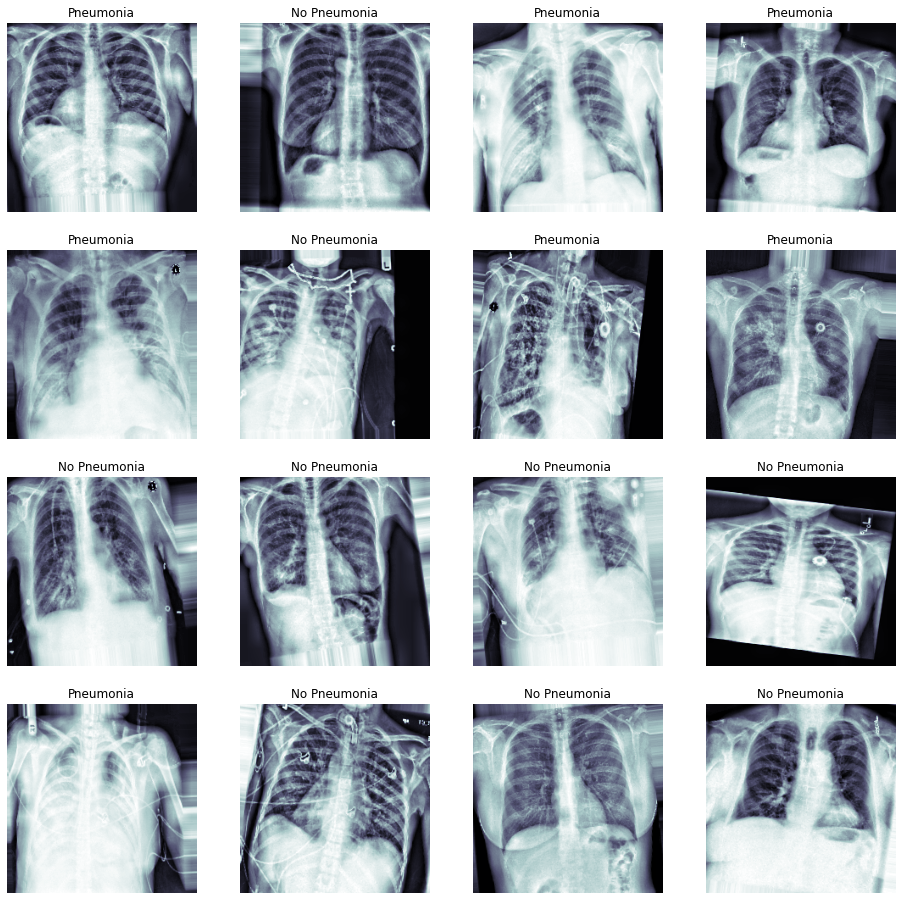

In [13]:
## May want to look at some examples of our augmented training data.
## This is helpful for understanding the extent to which data is being manipulated prior to training,
## and can be compared with how the raw data look prior to augmentation

trainX, trainY = next(train_gen)
visualization.batch_image_peak(trainX, trainY)

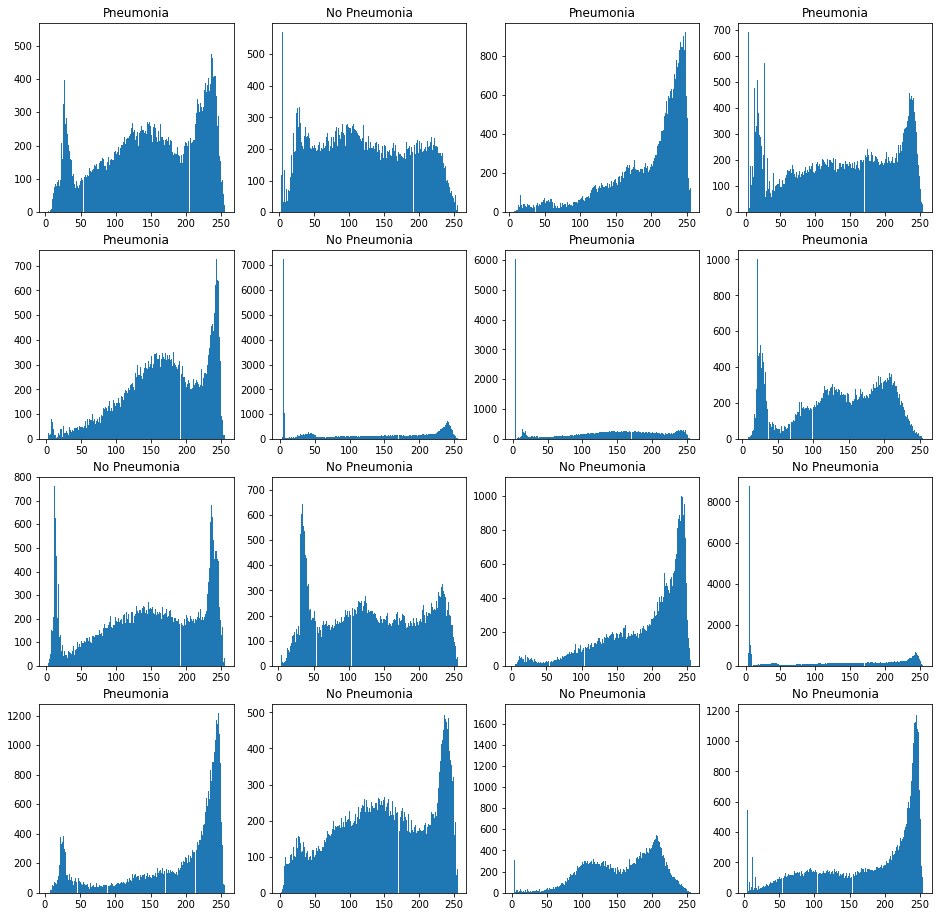

In [14]:
visualization.batch_histogram_peak(trainX, trainY)

#### Validation-set images


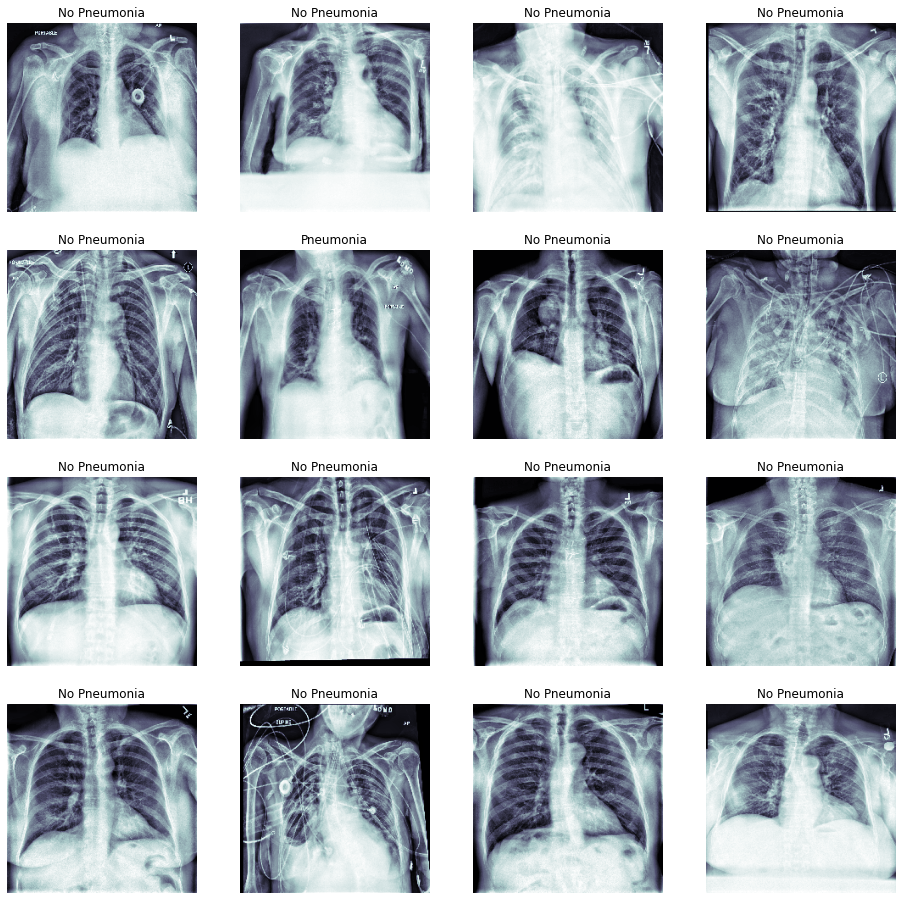

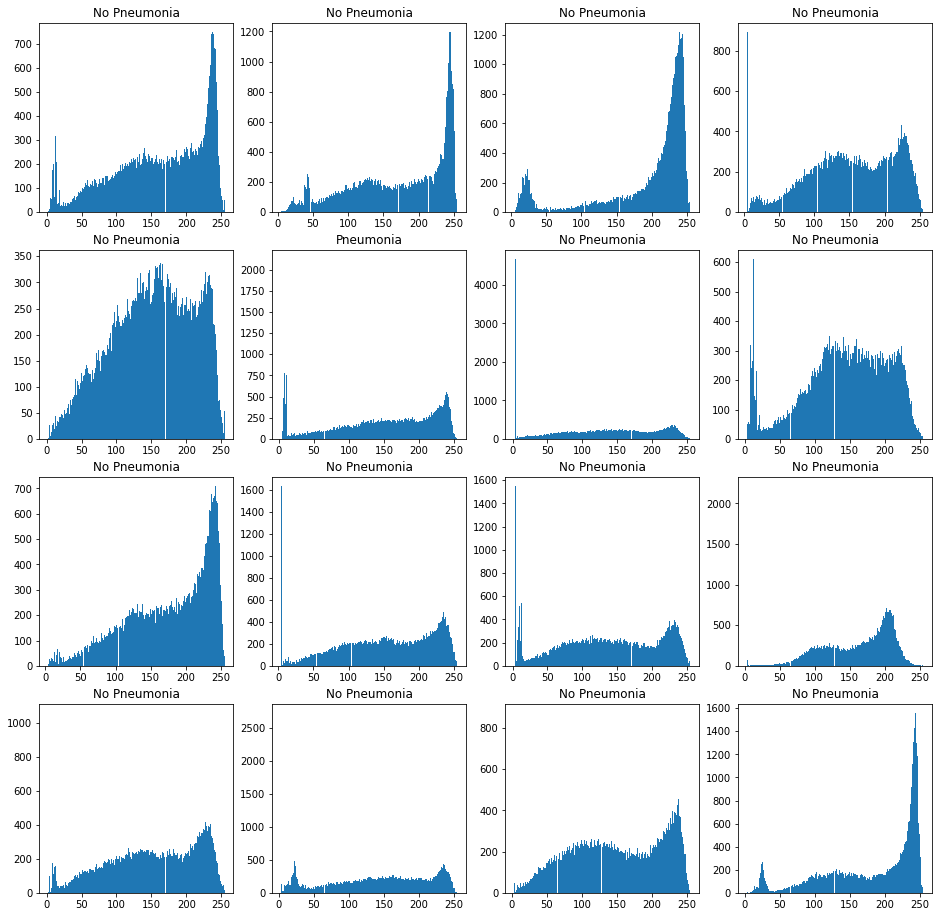

In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
visualization.batch_image_peak(valX, valY)
visualization.batch_histogram_peak(valX, valY)

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning


In [16]:
DropoutFactor = 0.5
WeightDecay = 1e-6

inputs = tf.keras.Input(shape=INPUT_SHAPE)

# pre_trained = models.VGG16(INPUT_SHAPE)
pre_trained = models.ResNet50(INPUT_SHAPE)
preprocessing = pre_trained.get_preprocessing()
# load pre-trained model
base_model = pre_trained.get_base_model()
base_model.trainable = False

x = preprocessing(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten(name='Flatten')(x)
x = tf.keras.layers.Dropout(DropoutFactor)(x)
x = tf.keras.layers.Dense(256, name='FC1', activation='relu')(x)
outputs = tf.keras.layers.Dense(1, name='prediction', activation='sigmoid')(x)
my_model = tf.keras.Model(inputs, outputs)

print(my_model.summary())
for layer in my_model.layers:
    print(f'{layer.name}: {layer.trainable}')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

2021-11-05 20:55:37.594119: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 20:55:37.594410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 20:55:37.594639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 20:55:37.594812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
ResNet50_preprocessing (Sequ (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
Flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               25690368  
_________________________________________________________________
prediction (Dense)           (None, 1)                 257   

In [17]:
PATIENCE = 15

METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
EVALUATION_MODE = 'auto'

weight_path = "{}.best.hdf5".format('warmup')

checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

early = EarlyStopping(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                      mode=EVALUATION_MODE,
                      patience=PATIENCE)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log/', histogram_freq=1)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                                                 factor=0.1,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='auto')

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

2021-11-05 20:55:39.261888: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-05 20:55:39.261907: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-05 20:55:39.261929: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-11-05 20:55:39.262170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-11-05 20:55:39.429790: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-05 20:55:39.429949: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [18]:
# Compile the model!
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training!

In [19]:
## train your model
MAX_EPOCHS = 50

history = my_model.fit(train_gen,
                       validation_data=val_gen,
                       epochs=MAX_EPOCHS,
                       class_weight=class_weight,
                       steps_per_epoch=steps_per_epoch,
                       validation_steps=validation_steps,
                       callbacks=callbacks_list
                       )

2021-11-05 20:55:40.056857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-05 20:55:42.832718: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-05 20:55:43.062053: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/43 [..............................] - ETA: 3:01 - loss: 1.0214 - binary_accuracy: 0.3125

2021-11-05 20:55:44.214661: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-05 20:55:44.317267: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-05 20:55:44.352732: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB 

 2/43 [>.............................] - ETA: 27s - loss: 1.2312 - binary_accuracy: 0.3281 

2021-11-05 20:55:45.088708: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-05 20:55:45.088890: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-05 20:55:45.128524: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 421 callback api events and 424 activity events. 
2021-11-05 20:55:45.136121: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-05 20:55:45.146635: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/profile/2021_11_05_20_55_45

2021-11-05 20:55:45.151838: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/train/plugins/profile/2021_11_05_20_55_45/perrusi-PC.trace.json.gz
2021-11-05 20:55:45.178982: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/p

10/43 [=====>........................] - ETA: 15s - loss: 0.7616 - binary_accuracy: 0.4811

2021-11-05 20:55:48.633831: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-05 20:55:48.670588: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


43/43 [==============================] - ETA: 0s - loss: 0.6298 - binary_accuracy: 0.5444 

2021-11-05 20:56:10.188082: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-05 20:56:10.250725: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


43/43 [==============================] - 52s 1s/step - loss: 0.6298 - binary_accuracy: 0.5444 - val_loss: 0.9529 - val_binary_accuracy: 0.5551


2021-11-05 20:56:32.322060: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-05 20:56:32.370374: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: val_loss improved from inf to 0.95285, saving model to warmup.best.hdf5


2021-11-05 20:56:36.238402: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3082813440 exceeds 10% of free system memory.


Epoch 2/50
43/43 [==============================] - 43s 1s/step - loss: 0.5165 - binary_accuracy: 0.5830 - val_loss: 0.7376 - val_binary_accuracy: 0.6501

2021-11-05 20:57:24.391952: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3082813440 exceeds 10% of free system memory.


Epoch 3/50
43/43 [==============================] - 43s 1s/step - loss: 0.4572 - binary_accuracy: 0.6004 - val_loss: 0.8213 - val_binary_accuracy: 0.5475

2021-11-05 20:58:11.006922: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3082813440 exceeds 10% of free system memory.


Epoch 4/50
43/43 [==============================] - 42s 987ms/step - loss: 0.4417 - binary_accuracy: 0.5910 - val_loss: 0.7307 - val_binary_accuracy: 0.5841

2021-11-05 20:58:57.733616: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3082813440 exceeds 10% of free system memory.


Epoch 5/50
43/43 [==============================] - 43s 999ms/step - loss: 0.3866 - binary_accuracy: 0.6179 - val_loss: 0.7331 - val_binary_accuracy: 0.5486

2021-11-05 20:59:43.801252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3082813440 exceeds 10% of free system memory.


Epoch 6/50
43/43 [==============================] - 43s 997ms/step - loss: 0.3715 - binary_accuracy: 0.5895 - val_loss: 0.6941 - val_binary_accuracy: 0.5939

### Fine-tunning

In [20]:
my_model.load_weights(weight_path)  # load early stopped weights

In [21]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_top_layers = pre_trained.get_fine_tuning_top_layer()

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_top_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_top_layers:]:
    layer.trainable = True

my_model.summary()
print(len(my_model.trainable_variables))

Number of layers in the base model:  175
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
ResNet50_preprocessing (Sequ (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
Flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               25690368  
_________________________________________________________________
prediction (Dense)  

In [22]:
# reset generators
train_gen.reset()
val_gen.reset()

# re-compile the model with a smaller learning rate
optimizer = Adam(learning_rate=1e-6)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

weight_path = "{}.best.hdf5".format('fine_tunning')
checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

In [23]:
## re-train your model
MAX_FINE_TUNED_EPOCHS = history.epoch[-1] + 50

history_fine = my_model.fit(train_gen,
                            validation_data=val_gen,
                            initial_epoch=history.epoch[-1],
                            epochs=MAX_FINE_TUNED_EPOCHS,
                            callbacks=callbacks_list,
                            class_weight=class_weight,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            )

Epoch 31/80


2021-11-05 21:19:11.121596: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-05 21:19:11.140443: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 1/43 [..............................] - ETA: 2:17 - loss: 0.2706 - binary_accuracy: 0.6497

2021-11-05 21:19:11.489492: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-05 21:19:11.489514: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 25s - loss: 0.2720 - binary_accuracy: 0.6514 

2021-11-05 21:19:12.248786: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-05 21:19:12.249653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-05 21:19:12.307389: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 670 callback api events and 673 activity events. 
2021-11-05 21:19:12.319965: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-05 21:19:12.336342: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/profile/2021_11_05_21_19_12

2021-11-05 21:19:12.345359: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/train/plugins/profile/2021_11_05_21_19_12/perrusi-PC.trace.json.gz
2021-11-05 21:19:12.378497: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/train/plugins/p

43/43 [==============================] - 47s 1s/step - loss: 0.2921 - binary_accuracy: 0.6678 - val_loss: 0.6407 - val_binary_accuracy: 0.6539

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

In [25]:
# Use model for inference on each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_predY = my_model.predict(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_predY = my_model.predict(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_predY = my_model.predict(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 260s 742ms/step

In [26]:
# Evaluate model for each dataset
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_eval = my_model.evaluate(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_eval = my_model.evaluate(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_eval = my_model.evaluate(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 232s 659ms/step - loss: 0.5604 - binary_accuracy: 0.7382

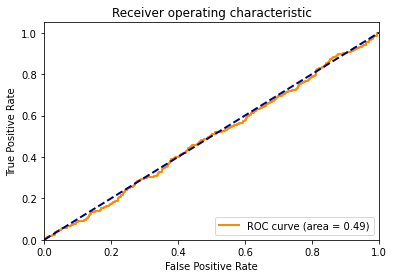

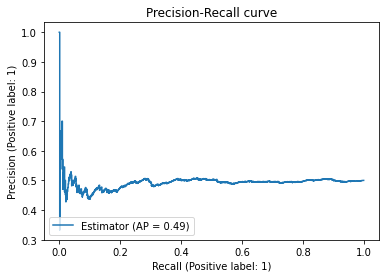

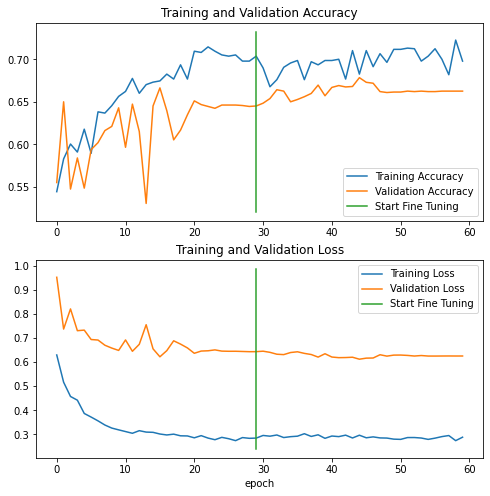

<Figure size 432x288 with 0 Axes>

In [27]:
## plot performance metrics
visualization.plot_auc(train_gen.labels, train_predY)
visualization.precision_recall(train_gen.labels, train_predY)
visualization.plot_history_fine(history, history_fine)


Now let's choose a threshold with desired precision/recall balance based on the training data

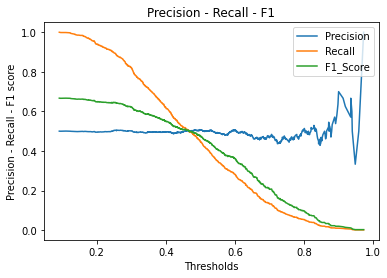

In [28]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(train_gen.labels, train_predY)
f1_scores = tools.compute_f1(precision, recall)
# precision = tools.remove_nan(precision)
# recall = tools.remove_nan(recall)
# thresholds = tools.remove_nan(thresholds)
# f1_scores = tools.remove_nan(f1_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
plt.show()

Chosen F1 score 0.3330106485963214, precision 0.4985507246376812, recall 0.25036390101892286 for threshold 0.6195862293243408


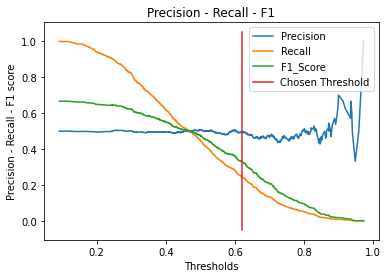

In [29]:
# idx = np.argmax(f1_scores[:-1])
# idx = np.argmax(precision[:-1])
# idx = tools.find_nearest_idx(recall, 0.8)
idx = tools.find_nearest_idx(thresholds, 0.62)

threshold = thresholds[idx]

print(f'Chosen F1 score {f1_scores[idx]}, precision {precision[idx+1]}, recall {recall[idx+1]} for threshold {threshold}')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.plot([threshold, threshold], plt.ylim(), label='Chosen Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score', 'Chosen Threshold'], loc='upper right')
plt.show()

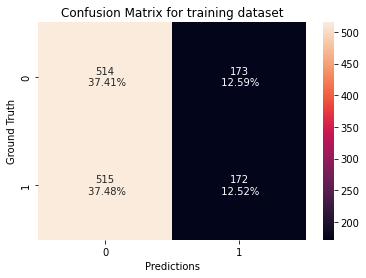

In [30]:
visualization.confusion_matrix(train_gen.labels, train_predY > threshold)
plt.title('Confusion Matrix for training dataset')
plt.show()

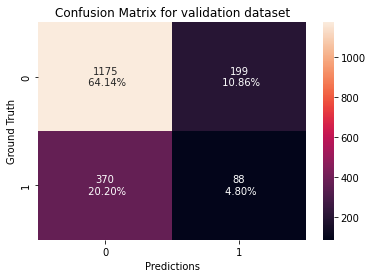

In [31]:
visualization.confusion_matrix(val_gen.labels, val_predY > threshold)
plt.title('Confusion Matrix for validation dataset')
plt.show()


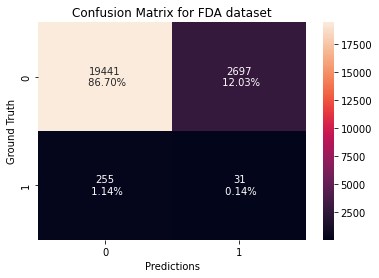

In [32]:
# Apply it to the FDA set
visualization.confusion_matrix(fda_gen.labels, fda_predY > threshold)
plt.title('Confusion Matrix for FDA dataset')
plt.show()


1/1 [==============================] - 1s 555ms/step


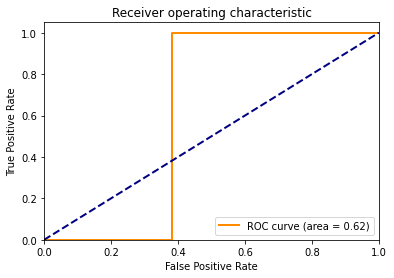

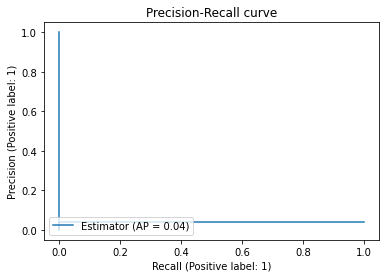

In [33]:
fda_gen.reset()
valX, valY = fda_gen.next()
batchY = my_model.predict(valX, batch_size=VALIDATION_BATCH, verbose=True)
visualization.plot_auc(valY, batchY)
visualization.precision_recall(valY, batchY)



Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

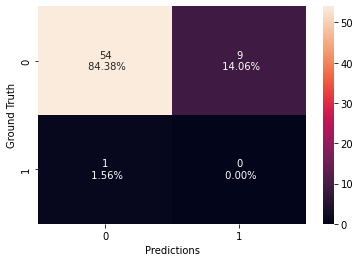

In [34]:
visualization.confusion_matrix(valY, batchY > threshold)
plt.show()

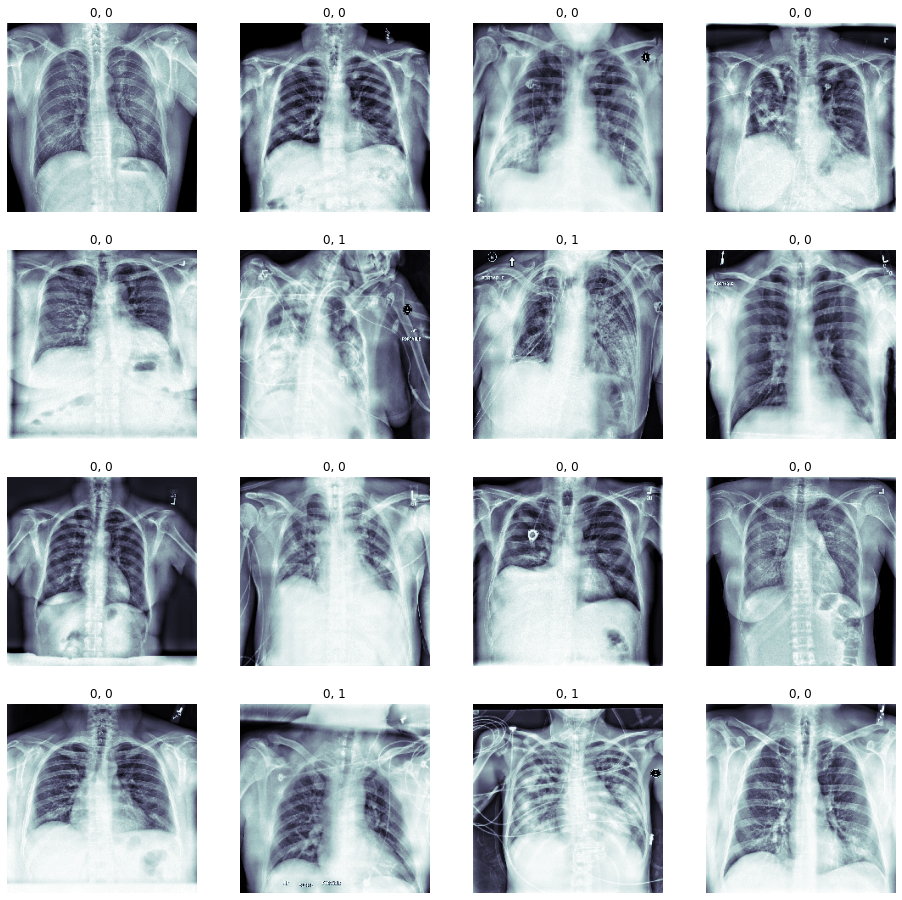

In [35]:
## Let's look at some examples of true vs. predicted with our best model:

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone')
    if c_y == 1:
        if batchY[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if batchY[i] > threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i = i + 1

In [36]:
## Just save model architecture to a .json:

my_model.save("my_model.h5")

In [37]:
import json

# Save it under the form of a json file
# json.dump(history.history, open('history.json', 'w'))
# json.dump(history_fine.history, open('history_fine.json', 'w'))

### References
* https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

